## Implementing everything together on Real dataset

In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.3 MB/s eta 0:00:00


In [2]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader,Dataset
import torch.optim as optimizer


from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score,KFold
import category_encoders as ce
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
# loading dataset
data=pd.read_csv('/content/modified.csv')
data.head(5)

,price,bedRoom,bathroom,balcony,floor_type,agePossession,sector,type,built_up_area,servant room,pooja room,furnishing_type,luxury
0,0.45,2.0,2.0,1,low floor,relatively new,sector 7,flat,900.0,no,no,unfurnished,low
1,0.50,2.0,2.0,1,low floor,old property,sector 3,flat,650.0,no,no,semifurnished,normal
2,0.40,2.0,2.0,3,high floor,new property,sohna road,flat,595.0,no,no,unfurnished,normal
3,1.47,2.0,2.0,2,low floor,new property,sector 61,flat,1200.0,no,no,unfurnished,semi_luxrious
4,0.70,2.0,2.0,3,mid floor,under construction,sector 92,flat,1076.0,no,no,unfurnished,low


In [4]:
data.columns

Index(['price', 'bedRoom', 'bathroom', 'balcony', 'floor_type',
       'agePossession', 'sector', 'type', 'built_up_area', 'servant room',
       'pooja room', 'furnishing_type', 'luxury'],
      dtype='object')

In [5]:
data.dtypes

,0
price,float64
bedRoom,float64
bathroom,float64
balcony,object
floor_type,object
agePossession,object
sector,object
type,object
built_up_area,float64
servant room,object


In [6]:
data.isnull().sum()

,0
price,0
bedRoom,0
bathroom,0
balcony,0
floor_type,0
agePossession,0
sector,0
type,0
built_up_area,0
servant room,0


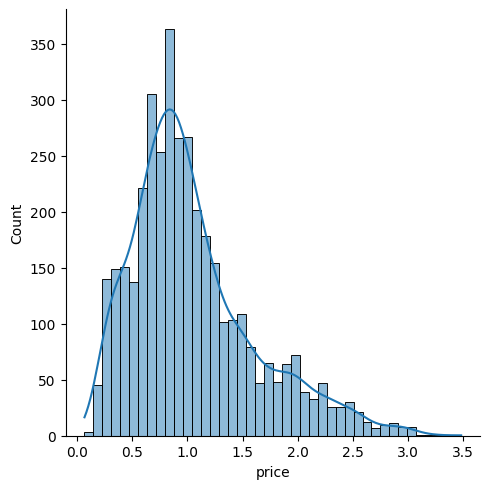

In [7]:
sns.displot(np.log1p(data['price']),kde=True) # np.log1p=np.log(1+x)

In [8]:
y = np.log1p(data['price'])
x = data.drop('price', axis=1)
# train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)
x_train

,bedRoom,bathroom,balcony,floor_type,agePossession,sector,type,built_up_area,servant room,pooja room,furnishing_type,luxury
1621,4.0,5.0,3+,mid floor,relatively new,sector 72,flat,3062.653000,yes,no,unfurnished,normal
3414,2.0,2.0,2,low floor,moderately old,sector 8,house,581.000000,no,no,unfurnished,low
246,3.0,3.0,3,mid floor,under construction,sector 62,flat,1600.000000,no,no,unfurnished,low
1886,3.0,3.0,1,low floor,relatively new,sector 48,flat,1450.000000,no,no,unfurnished,semi_luxrious
734,3.0,3.0,3+,mid floor,moderately old,sector 1,flat,2089.000000,yes,no,unfurnished,low
...,...,...,...,...,...,...,...,...,...,...,...,...
1130,3.0,3.0,1,high floor,relatively new,sector 86,flat,1330.000000,no,no,unfurnished,luxrious
1294,3.0,3.0,3,low floor,relatively new,sector 71,flat,1296.000000,no,no,semifurnished,normal
860,3.0,4.0,3,low floor,moderately old,sector 108,flat,1302.001344,no,no,semifurnished,semi_luxrious
3507,4.0,4.0,3+,low floor,relatively new,sector 109,house,5403.000000,yes,no,unfurnished,luxrious


In [9]:
# transformation

def transformation():

  transformer=ColumnTransformer(transformers=[
    ('tnf1',OneHotEncoder(drop='first',sparse_output=False,),['agePossession','type']),
    ('tnf2',OrdinalEncoder(categories=[['no','yes']]),['servant room']),
    ('tnf3',OrdinalEncoder(categories=[['no','yes']]),['pooja room']),
     ('tnf4',OrdinalEncoder(categories=[['groundfloor','mid floor','high floor','low floor','hometop']]),['floor_type']),
    ('tnf5',OrdinalEncoder(categories=[['low','normal','semi_luxrious','luxrious']]),['luxury']),
    ('tnf6',OrdinalEncoder(categories=[['1','0','2','3','3+']]),['balcony']),
    ('tnf7',OrdinalEncoder(categories=[['unfurnished', 'semifurnished', 'furnished']]),['furnishing_type']),
    ('tnf8',ce.TargetEncoder(),['sector']),
    ('tnf9',StandardScaler(),['built_up_area'])
    ],remainder='passthrough')

  return transformer



In [10]:
x_train.shape

(3044, 12)

In [11]:
y_train.shape

(3044,)

In [12]:
# transformation applied
transformer=transformation()
transformer.fit(x_train,y_train) # y_train required for target encoder
x_train_transformed=transformer.transform(x_train)
x_test_transformed=transformer.transform(x_test)

feature_names = transformer.get_feature_names_out()

In [13]:
feature_names.tolist()

['tnf1__agePossession_new property',
 'tnf1__agePossession_old property',
 'tnf1__agePossession_relatively new',
 'tnf1__agePossession_under construction',
 'tnf1__type_house',
 'tnf2__servant room',
 'tnf3__pooja room',
 'tnf4__floor_type',
 'tnf5__luxury',
 'tnf6__balcony',
 'tnf7__furnishing_type',
 'tnf8__sector',
 'tnf9__built_up_area',
 'remainder__bedRoom',
 'remainder__bathroom']

In [14]:
x_train_transformed.shape

(3044, 15)

In [15]:
x_test_transformed.shape

(761, 15)

In [16]:
pd.DataFrame(x_train_transformed, columns=feature_names)

,tnf1__agePossession_new property,tnf1__agePossession_old property,tnf1__agePossession_relatively new,tnf1__agePossession_under construction,tnf1__type_house,tnf2__servant room,tnf3__pooja room,tnf4__floor_type,tnf5__luxury,tnf6__balcony,tnf7__furnishing_type,tnf8__sector,tnf9__built_up_area,remainder__bedRoom,remainder__bathroom
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,4.0,0.0,1.389323,1.222003,4.0,5.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,2.0,0.0,0.943390,-0.965716,2.0,2.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,1.257134,-0.067409,3.0,3.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,1.705875,-0.199643,3.0,3.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,0.0,0.775269,0.363672,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3039,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.772828,-0.305429,3.0,3.0
3040,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,3.0,1.0,0.807512,-0.335402,3.0,3.0
3041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,3.0,1.0,1.018257,-0.330112,3.0,4.0
3042,0.0,0.0,1.0,0.0,1.0,1.0,0.0,3.0,3.0,4.0,0.0,1.460007,3.285153,4.0,4.0


In [17]:
torch.manual_seed(42) # set for reproducibility

In [18]:
# checking device avilability
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [19]:
class customdataset(Dataset):
  def __init__(self,x_train_transformed,y_train):
    self.x_tensor=torch.tensor(x_train_transformed,dtype=torch.float32)
    self.y_tensor=torch.tensor(y_train.to_numpy(),dtype=torch.float32)

  def __len__(self):
    return self.x_tensor.shape[0]

  def __getitem__(self,idx):
    return self.x_tensor[idx],self.y_tensor[idx]



obj=customdataset(x_train_transformed,y_train)
test=customdataset(x_test_transformed,y_test)

In [20]:
loader=DataLoader(obj,batch_size=32,shuffle=True,num_workers=2,pin_memory=True)

In [21]:
test_loader=DataLoader(test,batch_size=32,shuffle=False,num_workers=2,pin_memory=True)

In [22]:
# collate function by default in Dataloader no custom defnition

In [23]:
for batch_no, (batch_features, batch_labels) in enumerate(loader):
    df_features = pd.DataFrame(batch_features.numpy(), columns=feature_names)
    df_labels = pd.DataFrame(batch_labels.numpy(), columns=['price'])
    print(f"\nBatch {batch_no}")
    print(df_features.head())
    print(df_labels.head())
    break


Batch 0
   tnf1__agePossession_new property  tnf1__agePossession_old property  \
0                               0.0                               0.0   
1                               1.0                               0.0   
2                               0.0                               0.0   
3                               0.0                               0.0   
4                               0.0                               0.0   

   tnf1__agePossession_relatively new  tnf1__agePossession_under construction  \
0                                 1.0                                     0.0   
1                                 0.0                                     0.0   
2                                 1.0                                     0.0   
3                                 1.0                                     0.0   
4                                 0.0                                     0.0   

   tnf1__type_house  tnf2__servant room  tnf3__pooja room  tnf4__

In [42]:
# Defining Archtitecture and parameters

class MyAnn(nn.Module):
  def __init__(self,input_dim):
    super().__init__()

    # Intializing layers in sequential container
    self.model=nn.Sequential(
        # ist layer
        nn.Linear(out_features=12,in_features=input_dim),
        nn.BatchNorm1d(12,affine=True),
        nn.ReLU(),

        # 2nd layer
        nn.Linear(out_features=10,in_features=12),
        nn.BatchNorm1d(10,affine=True),
        nn.ReLU(),

        # 3rd layer
        nn.Linear(out_features=8,in_features=10),
        #nn.Dropout1d(p=0.2),
        nn.BatchNorm1d(8,affine=True),
        nn.ReLU(),

        # 4th layer
        nn.Linear(out_features=6,in_features=8),
        nn.BatchNorm1d(6,affine=True),
        nn.ReLU(),

        # 5th layer
        nn.Linear(out_features=4,in_features=6),
        nn.BatchNorm1d(4,affine=True),
        nn.ReLU(),
        # output
        nn.Linear(out_features=1, in_features=4)
      )

  def forward(self,train_data):
    output= self.model(train_data)
    return output.squeeze(1)



In [43]:
# making obj
input_dim=x_train_transformed.shape[1]
model=MyAnn(input_dim)
# moving to gpu
model=model.to(device)

In [44]:
model

MyAnn(
  (model): Sequential(
    (0): Linear(in_features=15, out_features=12, bias=True)
    (1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=12, out_features=10, bias=True)
    (4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=8, bias=True)
    (7): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=8, out_features=6, bias=True)
    (10): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=6, out_features=4, bias=True)
    (13): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=4, out_features=1, bias=True)
  )
)

In [45]:
def init_weights(parameter):
      # Intialized weights and bias
      if isinstance(parameter,nn.Linear):
        init.kaiming_uniform_(parameter.weight, nonlinearity='relu')

        if parameter.bias is  not None:
          init.zeros_(parameter.bias)

      # intializing gamma and betta of batchnorm
      elif isinstance(parameter,nn.BatchNorm1d):
        init.ones_(parameter.weight)
        init.zeros_(parameter.bias)

In [46]:
model.apply(init_weights)

MyAnn(
  (model): Sequential(
    (0): Linear(in_features=15, out_features=12, bias=True)
    (1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=12, out_features=10, bias=True)
    (4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=8, bias=True)
    (7): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=8, out_features=6, bias=True)
    (10): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=6, out_features=4, bias=True)
    (13): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=4, out_features=1, bias=True)
  )
)

In [47]:
model.state_dict()

OrderedDict([('model.0.weight',
              tensor([[-0.5453, -0.5477, -0.4425, -0.4162,  0.5845, -0.1715,  0.3262,  0.2606,
                        0.2353, -0.6177,  0.6160,  0.3909, -0.5895, -0.4157,  0.2633],
                      [-0.1302, -0.4448,  0.1163, -0.5942,  0.5090,  0.5261,  0.3310,  0.2941,
                       -0.3930, -0.0640,  0.3136,  0.1548,  0.5199,  0.1427, -0.5037],
                      [-0.4024,  0.4487,  0.3920,  0.1585,  0.0919,  0.3699, -0.6186, -0.6091,
                       -0.3128, -0.3020, -0.0726,  0.2739, -0.1700,  0.0127, -0.4864],
                      [-0.2628,  0.4952,  0.5034, -0.1597,  0.2480,  0.5228,  0.4667, -0.0130,
                       -0.4083, -0.1886,  0.3411, -0.2890,  0.3232, -0.4558,  0.2765],
                      [ 0.3960, -0.1117,  0.6268,  0.3850,  0.0138, -0.1384,  0.0476, -0.3538,
                       -0.0921, -0.5844,  0.2126,  0.0742, -0.4937, -0.1426,  0.2217],
                      [-0.3999,  0.2553, -0.4583,  0.0337,

In [48]:

start_time=time.time() # training_time

def updation(model,loader):
  epochs=500
  learning_rate=0.001
  loss_fxn=nn.MSELoss()
  opt=optimizer.Adam(model.parameters(),lr=learning_rate) # no need of weight_deacy dropout,batchnorm applied

  model.train() # so dropout,batchnorm behave normally


  for i in range(epochs):
    running_loss=0
    for batch_features,batch_labels in loader:

        # training on gpu
        batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
        # forward
        output=model(batch_features)

        # calculate loss
        loss=loss_fxn(output,batch_labels)
        running_loss+=loss.item()
        #
        opt.zero_grad()

        # claculation gradient
        loss.backward()
        # updation

        opt.step()

    # print loss for every 10 epochs
    if (i+1)%100==0:
     avg_loss=running_loss/len(loader) # len(loader)= no.of batches
     print(f"Epoch {i+1}, Loss after every 100 epochs: {avg_loss:.4f}")

# calling function
updation(model,loader)
end_time=time.time()

print(f"\n Training completed in {(end_time - start_time)/60:.2f} minutes")

Epoch 100, Loss after every 100 epochs: 0.0586
Epoch 200, Loss after every 100 epochs: 0.0556
Epoch 300, Loss after every 100 epochs: 0.0520
Epoch 400, Loss after every 100 epochs: 0.0515
Epoch 500, Loss after every 100 epochs: 0.0474

 Training completed in 5.24 minutes


In [49]:
# getting final parameter after training
model.state_dict()

OrderedDict([('model.0.weight',
              tensor([[-2.5917e-01, -4.1674e-01, -7.2923e-01, -6.7362e-01,  4.4405e-01,
                       -3.0725e-01, -4.0179e-02,  2.4692e-01,  1.0145e-01, -4.1680e-02,
                       -2.5850e-02,  2.4318e-01, -1.8725e+00, -1.5984e-01,  2.1594e-01],
                      [-1.0949e-01, -2.1507e-02,  2.9462e-01, -1.7428e-01,  1.3399e+00,
                        3.0267e-01,  3.3499e-01,  2.6648e-01, -3.2629e-01, -5.0610e-01,
                        3.8011e-01,  1.0347e+00,  2.3317e-01,  2.0101e-01, -2.3734e-02],
                      [ 1.9366e-01, -2.1286e-01,  4.5916e-01, -3.1600e-01,  8.3180e-01,
                        8.3428e-02,  9.6275e-03, -7.5545e-01,  1.2969e-01,  8.8019e-02,
                       -4.0267e-01,  7.8470e-02, -6.7581e-01,  1.5526e-01, -2.4649e-01],
                      [ 4.9397e-02,  3.3145e-01,  2.2916e-01, -1.0383e+00, -1.0840e-01,
                       -2.4996e-01, -6.3456e-02,  3.6945e-01, -2.3884e-01, -2.9717e-0

In [50]:
preds = []
actuals = []

with torch.inference_mode():
    for batch_features, batch_labels in test_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        batch_preds = model(batch_features)  # output shape: [batch_size]
        preds.append(batch_preds.cpu())      # don't squeeze again
        actuals.append(batch_labels.cpu())   # keep as-is

# Concatenate all batches
preds_all = torch.cat(preds).numpy()
actuals_all = torch.cat(actuals).numpy()

preds_all = np.expm1(preds_all)
actuals_all = np.expm1(actuals_all)

# Metrics
r2 = r2_score(actuals_all, preds_all)
mse = mean_squared_error(actuals_all, preds_all)

print(f"Test R² score: {r2:.4f}")
print(f"Test MSE: {mse:.4f}")

Test R² score: 0.8005
Test MSE: 1.5680


In [51]:
model.eval()
train_preds = []
train_actuals = []

with torch.inference_mode():
    for batch_features, batch_labels in loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        batch_pred = model(batch_features)
        train_preds.append(batch_pred.cpu())
        train_actuals.append(batch_labels.cpu())

train_preds_all = torch.cat(train_preds).numpy()
train_actuals_all = torch.cat(train_actuals).numpy()

# If log1p was used during preprocessing
train_preds_all = np.expm1(train_preds_all)
train_actuals_all = np.expm1(train_actuals_all)

# Calculate scores
train_r2 = r2_score(train_actuals_all, train_preds_all)
train_mse = mean_squared_error(train_actuals_all, train_preds_all)

print(f"Train R² score: {train_r2:.4f}")
print(f"Train MSE: {train_mse:.4f}")


Train R² score: 0.8020
Train MSE: 1.5569
